# Single Objective Optimization of 3D Printed Materials

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgbaird/honegumi/blob/main/docs/curriculum/tutorials/sobo/sobo-tutorial.ipynb)

In [1]:
try:
    import google.colab
    %pip install ax-platform
except:
    print("Not running in Google Colab")

Not running in Google Colab


Imagine you are given the task of optimizing the parameters of a 3D printer to maximize the strength of a printed part. You believe Bayesian optimization can help you in this task and decide to put together a simple optimization script using Honegumi. 

Looking at the printer's settings, you see that the following parameters can be adjusted within the specified bounds:

| | **Parameter Name** | **Bounds**                              |
|------|--------------------|-----------------------------------------|
| x1   | X Offset           | [-1.0, 1.0]                                 |
| x2   | Y Offset           | [-1.0, 1.0]                                 |
| x3   | Infill Density     | [0.0, 1.0]                                  |
| x4   | Layer Height       | [0.0, 1.0]                                  |
| c1   | Infill Type        | [honeycomb, gyroid, lines, rectilinear] |

In addition to tight time constraints (number of optimization trials $\le$ 30), your manager tells you that the cost of printing the part cannot exceed $13. The print cost can be computed as a function of the `infill density` and `layer height` using the following linear equation: `cost = $16.32 * infill_density - $3.73 * layer_height`

A dummy objective function has been constructed in the code cell below to emulate the results of experimental trials under different inputs. Although we can easily find the optimal value using the equation, we will pretend that the objective function is unknown and use a Bayesian optimization approach to find the optimal set of input parameters instead.

In [2]:
import numpy as np

def gauss(x, mean, std):
    return np.exp(-(((x - mean) / std) ** 2))

def measure_strength(x1, x2, x3, x4, c1):
    """
    Calculates the printed strength based on the given input parameters.

    Parameters:
    x1 (float): x_offset [-1.0, 1.0].
    x2 (float): y_offset [-1.0, 1.0].
    x3 (float): infill_density [0.0, 1.0].
    x4 (float): layer_height [0.0, 1.0].
    c1 (str): The type of infill type ["honeycomb", "gyroid", "lines", "rectilinear"].

    Returns:
    float: The calculated printed strength.
    """

    y = float(
        gauss(x1, 0.25, 0.5) + gauss(x2, -1, 1.0) \
        + gauss(x3, 0.865, 0.3) + gauss(x4, 0.29, 0.25)
    ) * 20

    infill_effects = {
        'honeycomb': 1,
        'gyroid': 1.5,
        'lines': 0.5,
        'rectilinear': 0.8
    }

    y *= infill_effects[c1]

    return y

## Applying Honegumi

We will now use the [Honegumi website](https://honegumi.readthedocs.io/en/latest/) to generate a script that will help us optimize the printer parameters. From the description, we observe that our problem is a **single objective** optimization problem with an added **categorical variable** input and a **linear constraint** on the cost. To create an optimization script for this problem, we select the following options:

![Honegumi Selections for Single Objective Optimization](single_objective_selections.png)

The Honegumi generated optimization script will provide a framework for our optimization campaign that we can modify to suit our specific problem needs. In the code sections below, we will make several modifications to this generated script to make it compatible with our problem.

## Modifying the Code for Our Problem

We can modify this code to suit our problem with a few simple modifications. Wherever a modification has been made to the code, a comment starting with `# MOD:` has been added along with a brief description of the change.

In [ ]:
import numpy as np
import pandas as pd
from ax.service.ax_client import AxClient, ObjectiveProperties
import matplotlib.pyplot as plt

obj1_name = "printed_strength" # MOD: change objective name

# MOD: Remove the branin dummy objective function, we will use the printer function

ax_client = AxClient(random_seed=42) # MOD: add a random seed for repeatability

ax_client.create_experiment(
    parameters=[
        {"name": "x1", "type": "range", "bounds": [-1.0, 1.0]}, # MOD: update param
        {"name": "x2", "type": "range", "bounds": [-1.0, 1.0]}, # MOD: update param
        {"name": "x3", "type": "range", "bounds": [0.0, 1.0]}, # MOD: add new param
        {"name": "x4", "type": "range", "bounds": [0.0, 1.0]}, # MOD: add new param
        {
            "name": "c1",
            "type": "choice",
            "is_ordered": False,
            "values": ["honeycomb", "gyroid", "lines", "rectilinear"] # MOD: categories
        },
    ],
    parameter_constraints=[
        "16.32*x3 - 3.73*x4 <= 13.0", # MOD: update linear constraint with cost func
    ],
    objectives={
        obj1_name: ObjectiveProperties(minimize=False), # MOD: set minimize = FALSE
    },
)

for _ in range(19):

    parameterization, trial_index = ax_client.get_next_trial()

    # MOD: pull all added parameters from the parameterization
    x1 = parameterization["x1"]
    x2 = parameterization["x2"]
    x3 = parameterization["x3"]
    x4 = parameterization["x4"]
    c1 = parameterization["c1"]

    results = measure_strength(x1, x2, x3, x4, c1) # MOD: use measure_strength function
    ax_client.complete_trial(trial_index=trial_index, raw_data=results)

best_parameters, metrics = ax_client.get_best_parameters()

> NOTE: The output of the above cell has been hidden in the interest of clarity.

[WARNING 01-28 12:40:00] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


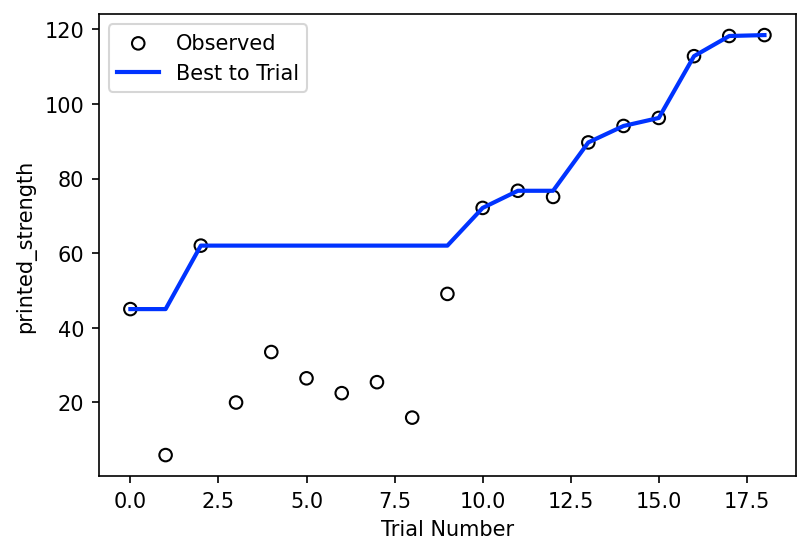

In [5]:
# Plot results
objectives = ax_client.objective_names
df = ax_client.get_trials_data_frame()

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.scatter(df.index, df[objectives], ec="k", fc="none", label="Observed")
ax.plot(
    df.index,
    np.maximum.accumulate(df[objectives]), # MOD: change to maximum
    color="#0033FF",
    lw=2,
    label="Best to Trial",
)
ax.set_xlabel("Trial Number")
ax.set_ylabel(objectives[0])

ax.legend()
plt.show()

## Show the Best Parameters

After our optimization loop has completed, we can use the model to find the best parameters and their corresponding strength value. These will be our optimial set of parameters that we use in the 3D printer going forward.

In [6]:
ax_client.get_best_trial()

(18,
 {'x1': 0.500359951513818,
  'x2': -0.46033699646058623,
  'x3': 0.8285536539122308,
  'x4': 0.13994520961067886,
  'c1': 'gyroid'},
 ({'printed_strength': 96.21959964090584},
  {'printed_strength': {'printed_strength': 0.07666070387120208}}))

## Next Steps

Interested in taking this further? Try to implement the following on your own!

1. Extend the total number of trials and determine how many iterations it takes to converge to the true optimal value. How much better was the true optima compared to what was found in the tutorial?

2. Select `Custom Model` in honegumi and vary the number of sobol trials. Is there an advantage to adding an additional five sobol trials? 